# <center>COMPUTER VISION - EfficientNetB0 MODEL</center>
***
## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. CONSTANTS<br>
> C. COLLECTING DATA AND LOADING A SAMPLE<br>
> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> E. PREPARATION OF DATA WITH PREPROCESSING<br>

## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE<br>
> B. EARLY STOPPING<br>

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF EfficientNetB0 PRE-TRAINED MODEL<br>
> B. MODEL CREATION WITH LAST LAYERS<br>
> C. COMPILING AND TRAINING<br>
> D. TRAINING HISTORY<br>
> E. CONFUSION MATRIX<br>
> F. CLASSIFICATION REPORT<br>

## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF TOP LAYERS OF EfficientNetB0<br>
> B. COMPILING AND TRAINING<br>
> C. TRAINING HISTORY<br>
> D. CONFUSION MATRIX<br>
> E. CLASSIFICATION REPORT<br>

## <font color = blue>V. WRONG PREDICTIONS</font>
***
##### Additional information before to get started :
* Recommended resolution for the pre-trained EfficientNetB0 model : (224, 224, 3).
    * https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
* For B0 to B7 base models, the input shapes are different. Here is a list of input shape expected for each model:
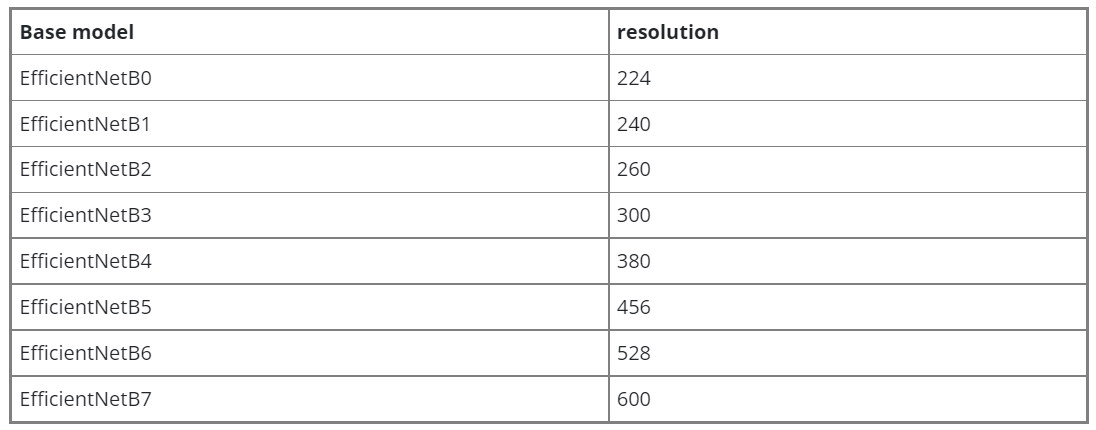
* EfficientNet preprocessing method has been included in the efficientnet model implementation. Users are no longer required to call this method to normalize the input data. This method does nothing. However, we kept it as we need a preprocessing method in our own build load_image method.

##### Laptop specification :
* OS: Windows 11
* Processor: AMD Ryzen 7 5800HS with Radeon Graphics 3.20 GHz
* Installed RAM: 16,0 GB
* GPU: NVIDIA GetForce RTX3080 8GB
***

## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from time import time

from helpers import load_image, show_wrong_predictions, confusion_matrix, global_classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools

import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import layers

> B. CONSTANTS

In [2]:
BATCH_SIZE       = 8                 # Bacth size for dataset
TARGET_SIZE      = (224, 224)        # Resolution of images before training
INPUT_SHAPE      = (224, 224, 3)     # Resolution of images with channels before training
IMAGES_DIRECTORY = '../data/final/'  # Directory where are located images

SAVED_WEIGHTS    = './model/model_EfficientNetB0.h5'  # File name where are saved the final weights of the model

> C. COLLECTING DATA AND LOADING A SAMPLE

In [3]:
df = pd.read_csv('../data/data.csv')
df.head()

Unnamed: 0.1  Unnamed: 0         filename  \
0             0           0  img_0000000.jpg   
1             1           1  img_0000001.jpg   
2             2           2  img_0000002.jpg   
3             3           3  img_0000003.jpg   
4             4           4  img_0000004.jpg   

                                                 url  \
0  https://templates.invoicehome.com/modele-factu...   
1  https://templates.invoicehome.com/modele-factu...   
2  https://www.coover.fr/wp-content/uploads/2021/...   
3  https://templates.invoicehome.com/modele-factu...   
4  https://files.intum.com/v/vosfactures/files/31...   

                                         description     type  \
0  100 modèles gratuits de factures | Téléchargem...  facture   
1  100 modèles gratuits de factures | Téléchargem...  facture   
2  Facture proforma : modèle à télécharger gratui...  facture   
3  100 modèles gratuits de factures | Téléchargem...  facture   
4  Base de Connaissances - Vos Factures - Créer u...  facture   

                  filepath  scraped     old_filename  \
0  ./final/img_0000000.jpg        1  img_0000000.jpg   
1  ./final/img_0000001.jpg        1  img_0000001.jpg   
2  ./final/img_0000002.jpg        1  img_0000002.jpg   
3  ./final/img_0000003.jpg        1  img_0000003.jpg   
4  ./final/img_0000004.jpg        1  img_0000004.jpg   

                old_filepath  ...  \
0  ./facture/img_0000000.jpg  ...   
1  ./facture/img_0000001.jpg  ...   
2  ./facture/img_0000002.jpg  ...   
3  ./facture/img_0000003.jpg  ...   
4  ./facture/img_0000004.jpg  ...   

                                            text_ocr  words_count  \
0   FACTURE LOGO Joanna Binet 48 Coubertin 31400 ...           98   
1   Joanna Binet 48 Coubertin 31400 Paris FACTURE...           97   
2   FACTURE Mon entreprise : Nom de la société Ad...           45   
3   Joanna Binet 48 Coubertin 31400 Paris FACTURE...           99   
4   Payer en ligne > FACTURE No SFIDELI F/05.2020...          157   

                                             text_en  \
0  Invoice Logo Joanna Binet Coubertin Paris Invo...   
1  Joanna Binet Coubertin Paris Invoice Invoice i...   
2  Invoice My company : Company name Mail address...   
3  Joanna Binet Coubertin Paris Bill To Cinderell...   
4  Pay online Invoice No Sfideli F/ Creation date...   

                                             text_fr  \
0   Facture Logo Joanna Binet  Coubertin  Paris F...   
1   Joanna Binet  Coubertin  Paris Facture Factur...   
2   Facture Mon entreprise : Nom de la société Ad...   
3   Joanna Binet  Coubertin  Paris Facture À Cend...   
4   Payer en ligne  Facture No Sfideli F/ Date de...   

                                        text_fr_norm  \
0  facture logo joanna binet coubertin paris fact...   
1  joanna binet coubertin paris facture facturé c...   
2  facture entreprise société adresse postale adr...   
3  joanna binet coubertin paris facture cendrillo...   
4  payer ligne facture sfideli date création date...   

                                        text_en_norm  target_en target_fr  \
0  invoice logo joanna binet coubertin paris invo...    invoice   facture   
1  joanna binet coubertin paris invoice invoice c...    invoice   facture   
2  invoice company company name mail address tele...    invoice   facture   
3  joanna binet coubertin paris bill cinderella a...    invoice   facture   
4  online invoice sfideli creation date validity ...    invoice   facture   

    target target_min  
0  invoice    invoice  
1  invoice    invoice  
2  invoice    invoice  
3  invoice    invoice  
4  invoice    invoice  

[5 rows x 27 columns]

In [4]:
df[['height', 'width']].describe(percentiles = [0.02, 0.05, 0.1, 0.2])

height        width
count  1308.000000  1308.000000
mean    822.093272   819.601682
std     446.387685   450.261632
min     133.000000   150.000000
2%      178.000000   212.000000
5%      200.000000   270.350000
10%     270.000000   362.000000
20%     421.800000   577.800000
50%    1000.000000   754.000000
max    4455.000000  4700.000000

We observe that less than 5% of images got a height lower than 200. The selection of EfficientNetB0 which has been trained with resolution (224, 224) makes sense.

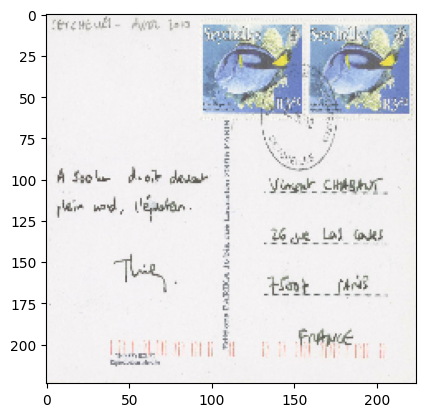

In [5]:
# Display a document randomly
num_alea = np.random.randint(len(df))

plt.imshow(load_image(directory = IMAGES_DIRECTORY,
                      filename = df.filename[num_alea],
                      preprocess = preprocess_input).numpy().astype("uint8"));

#Comments:
#- The method load_image is resizing images to (224, 224) by default,

> D. SPLIT BETWEEN TRAINING SET AND TEST SET

In [6]:
X_train_path, X_test_path, y_train, y_test = train_test_split(df.filename, df.target_min,
                                                              test_size = 0.2, random_state = 1234)

data_train ={'filename': X_train_path, 'type': y_train.astype('category')}
df_train = pd.DataFrame(data_train)

data_test ={'filename': X_test_path, 'type': y_test.astype('category')}
df_test = pd.DataFrame(data_test)

> E. PREPARATION OF DATA WITH PREPROCESSING

In [7]:
# Images generator for training set
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)      # data preprocessing


# Generator for test set (we don't increase the test set)
test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train,          # Dataframe
                                                           directory = IMAGES_DIRECTORY,  # Directory with pics
                                                           class_mode = 'categorical',    # Multiple classes
                                                           target_size = TARGET_SIZE,     # Resizing
                                                           x_col = 'filename',            # Column with filenames
                                                           y_col = 'type',                # Column with classes
                                                           batch_size = BATCH_SIZE)       # Batch size

test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test,             # Dataframe
                                                         directory = IMAGES_DIRECTORY,    # Directory with pics
                                                         class_mode = 'categorical',      # Multiple classes
                                                         target_size = TARGET_SIZE,       # Resizing
                                                         x_col = 'filename',              # Column with filenames
                                                         y_col = 'type',                  # Column with classes
                                                         batch_size = BATCH_SIZE)         # Batch size

Found 1046 validated image filenames belonging to 14 classes.
Found 262 validated image filenames belonging to 14 classes.


## <font color = blue>II. CALL BACKS</font>
> A. AUTOMATIC REDUCTION OF THE LEARNING RATE

In [8]:
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',                # Metric to control
                                         patience = 3,                        # Number of epochs to wait before decreasing the learning rate
                                         factor = 0.1,
                                         verbose = 2,                         # Number of informations displayed during training
                                         mode = 'min')                        # Indicate the metric decrease

> B. EARLY STOPPING

In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',          # Metric to control
                                         patience = 9,                  # Number of epochs to wait before stopping the training
                                         mode = 'min',                  # Indicate the metric decrease
                                         restore_best_weights = True)   # To restore the weights of the best epoch

## <font color = blue>III. TRANSFER LEARNING</font>
> A. LOADING OF EfficientNetB0 PRE-TRAINED MODEL

In [10]:
# Loading
efficientnet = EfficientNetB0(include_top = False, input_shape = INPUT_SHAPE)

# Freezing weigths
for layer in efficientnet.layers:
    layer.trainable = False

efficientnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2b_e

 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_bn (BatchNormalization  (None, 28, 28, 240)  960        ['block3b_dwconv[0][0]']         
 )        

 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5c_d

 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
                                                                                                  
 block6c_e

 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
          

> B. MODEL CREATION WITH LAST LAYERS

In [11]:
model = Sequential()
model.add(efficientnet)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 14, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

> C. COMPILING AND TRAINING

In [12]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),              # loss function
              optimizer = tf.keras.optimizers.Adam(),                        # optimizer algorithm
              metrics = ['accuracy'])                                        # metric

In [13]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                     # Training data
                    validation_data = test_generator,                        # Validation data
                    epochs = 50,                                             # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // BATCH_SIZE,     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // BATCH_SIZE,     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                # Callbacks
                    workers = -1)                                            # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


130/130 [==============================] - 33s 229ms/step - loss: 1.3747 - accuracy: 0.5511 - val_loss: 1.1209 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/50
130/130 [==============================] - 29s 226ms/step - loss: 0.8417 - accuracy: 0.7322 - val_loss: 1.0989 - val_accuracy: 0.6523 - lr: 0.0010
Epoch 3/50
130/130 [==============================] - 30s 228ms/step - loss: 0.7001 - accuracy: 0.7514 - val_loss: 0.9483 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/50
130/130 [==============================] - 31s 235ms/step - loss: 0.6193 - accuracy: 0.7842 - val_loss: 1.0770 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 5/50
130/130 [==============================] - 31s 236ms/step - loss: 0.5747 - accuracy: 0.8112 - val_loss: 1.0806 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 6/50
130/130 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.8285
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
130/130 [==============================] - 31s 2

> D. TRAINING HISTORY

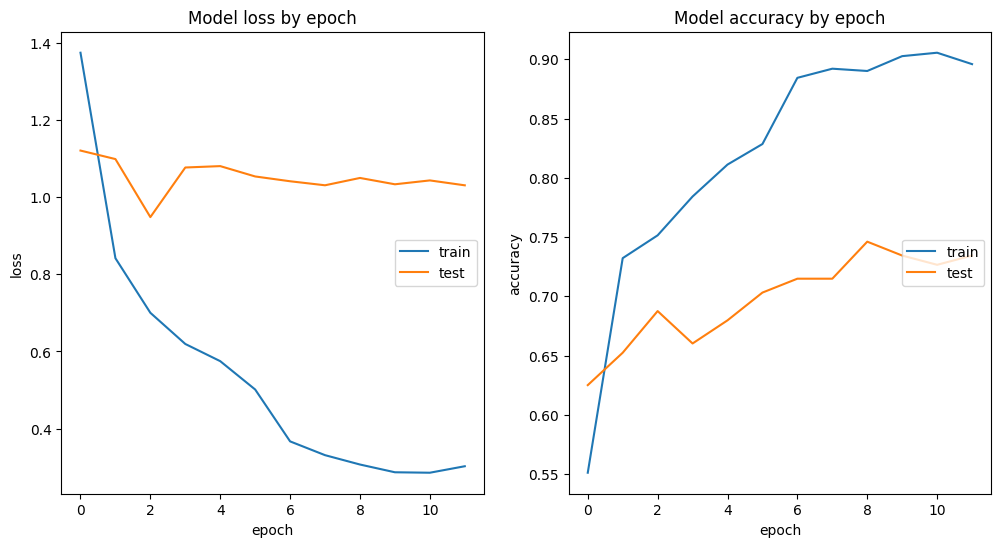

In [14]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> E. CONFUSION MATRIX

In [15]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


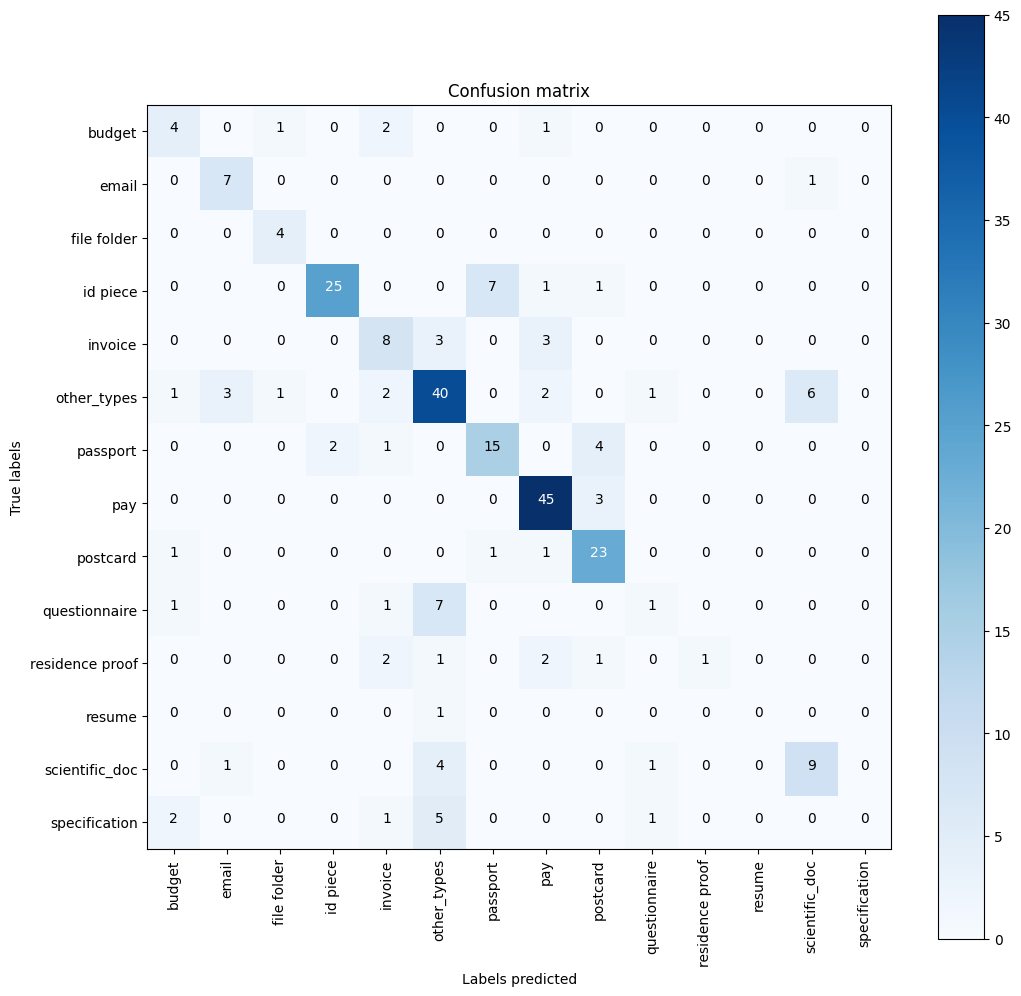

In [16]:
# Dictionaries for target
dico_type = test_generator.class_indices
dico_type_inv = {v: k for k, v in dico_type.items()}

# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

confusion_matrix(y_test, y_pred_type)

> F. CLASSIFICATION REPORT

In [17]:
print( classification_report(y_test, y_pred_type) )

                 precision    recall  f1-score   support

         budget       0.44      0.50      0.47         8
          email       0.64      0.88      0.74         8
    file folder       0.67      1.00      0.80         4
       id piece       0.93      0.74      0.82        34
        invoice       0.47      0.57      0.52        14
    other_types       0.66      0.71      0.68        56
       passport       0.65      0.68      0.67        22
            pay       0.82      0.94      0.87        48
       postcard       0.72      0.88      0.79        26
  questionnaire       0.25      0.10      0.14        10
residence proof       1.00      0.14      0.25         7
         resume       0.00      0.00      0.00         1
 scientific_doc       0.56      0.60      0.58        15
  specification       0.00      0.00      0.00         9

       accuracy                           0.69       262
      macro avg       0.56      0.55      0.52       262
   weighted avg       0.67   

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## <font color = blue>IV. FINE TUNING</font>
> A. UNFREEZING WEIGHTS OF TOP LAYERS OF EfficientNetB0

<font color = red>We unfreeze the top 8 layers while leaving BatchNorm layers frozen.</font>

In [18]:
for layer in efficientnet.layers[-8:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

> B. COMPILING AND TRAINING

In [19]:
last_learning_rate = model.optimizer.learning_rate.numpy()              # collect last learning rate from previous training

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),                            # loss function
              optimizer = tf.keras.optimizers.Adam(learning_rate = last_learning_rate),    # optimizer algorithm
              metrics = ['accuracy'])                                                      # metric

In [20]:
# Initialization of a timer
t0 = time()

history = model.fit(x = train_generator,                                     # Training data
                    validation_data = test_generator,                        # Validation data
                    epochs = 50,                                             # Number of epoch
                    steps_per_epoch = (len(X_train_path)) // BATCH_SIZE,     # Number of steps per Epoch
                    validation_steps = (len(X_test_path)) // BATCH_SIZE,     # Number of iterations during the test  
                    callbacks = [lr_plateau, early_stopping],                # Callbacks
                    workers = -1)                                            # Using all processors

# Calulation of training time
t1 = time() - t0
print("Training time in {} minutes".format(t1 // 60))

Epoch 1/50


C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


130/130 [==============================] - 29s 222ms/step - loss: 0.6128 - accuracy: 0.7890 - val_loss: 0.9238 - val_accuracy: 0.7031 - lr: 1.0000e-06
Epoch 2/50
130/130 [==============================] - 30s 230ms/step - loss: 0.5902 - accuracy: 0.8025 - val_loss: 0.8923 - val_accuracy: 0.7188 - lr: 1.0000e-06
Epoch 3/50
130/130 [==============================] - 29s 227ms/step - loss: 0.5508 - accuracy: 0.8227 - val_loss: 0.8960 - val_accuracy: 0.7148 - lr: 1.0000e-06
Epoch 4/50
130/130 [==============================] - 29s 225ms/step - loss: 0.5419 - accuracy: 0.8285 - val_loss: 0.8634 - val_accuracy: 0.7305 - lr: 1.0000e-06
Epoch 5/50
130/130 [==============================] - 29s 222ms/step - loss: 0.5481 - accuracy: 0.8208 - val_loss: 0.8939 - val_accuracy: 0.7148 - lr: 1.0000e-06
Epoch 6/50
130/130 [==============================] - 29s 226ms/step - loss: 0.5574 - accuracy: 0.8170 - val_loss: 0.8912 - val_accuracy: 0.7148 - lr: 1.0000e-06
Epoch 7/50
130/130 [===================

In [21]:
####### SAVING WEIGHTS #######
model.save_weights(SAVED_WEIGHTS)

> C. TRAINING HISTORY

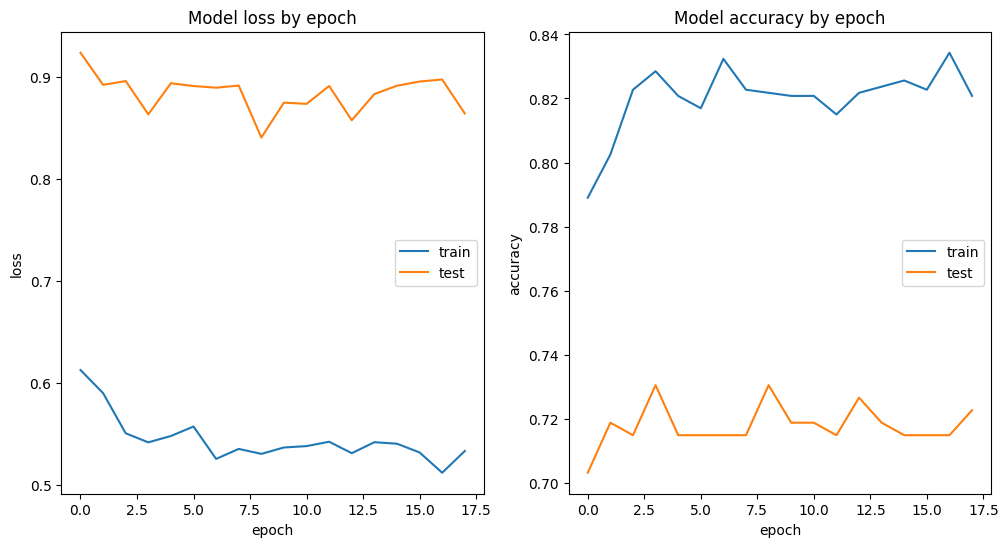

In [22]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX

In [23]:
# Probability predictions
X_test = [load_image(directory = IMAGES_DIRECTORY, filename = x, preprocess = preprocess_input) for x in X_test_path]
y_prob = [model.predict(np.array([x], dtype = np.float32))[0] for x in X_test]

# Class predictions
y_pred = tf.argmax(y_prob, axis = -1).numpy()

1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 98ms/step


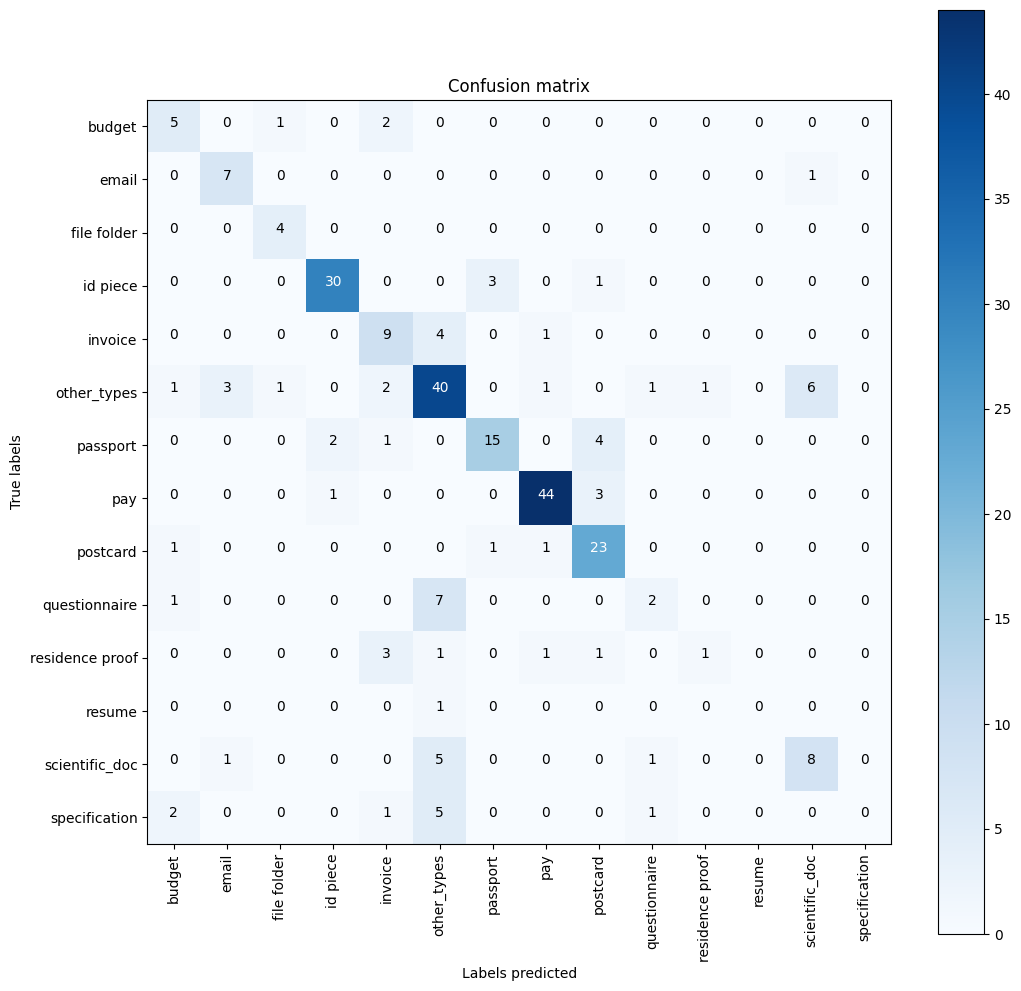

In [24]:
# Class predictions with type (passport, resume, etc...)
y_pred_type = pd.DataFrame(y_pred, index = y_test.index).replace(dico_type_inv)

confusion_matrix(y_test, y_pred_type)

> E. CLASSIFICATION REPORT

In [25]:
global_classification_report(y_test, y_pred_type, classifier = "EfficientNetB0", category = "ComputerVision target_min")

                 precision    recall  f1-score   support

         budget       0.50      0.62      0.56         8
          email       0.64      0.88      0.74         8
    file folder       0.67      1.00      0.80         4
       id piece       0.91      0.88      0.90        34
        invoice       0.50      0.64      0.56        14
    other_types       0.63      0.71      0.67        56
       passport       0.79      0.68      0.73        22
            pay       0.92      0.92      0.92        48
       postcard       0.72      0.88      0.79        26
  questionnaire       0.40      0.20      0.27        10
residence proof       0.50      0.14      0.22         7
         resume       0.00      0.00      0.00         1
 scientific_doc       0.53      0.53      0.53        15
  specification       0.00      0.00      0.00         9

       accuracy                           0.72       262
      macro avg       0.55      0.58      0.55       262
   weighted avg       0.69   

C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

## <font color = blue>V. WRONG PREDICTIONS</font>

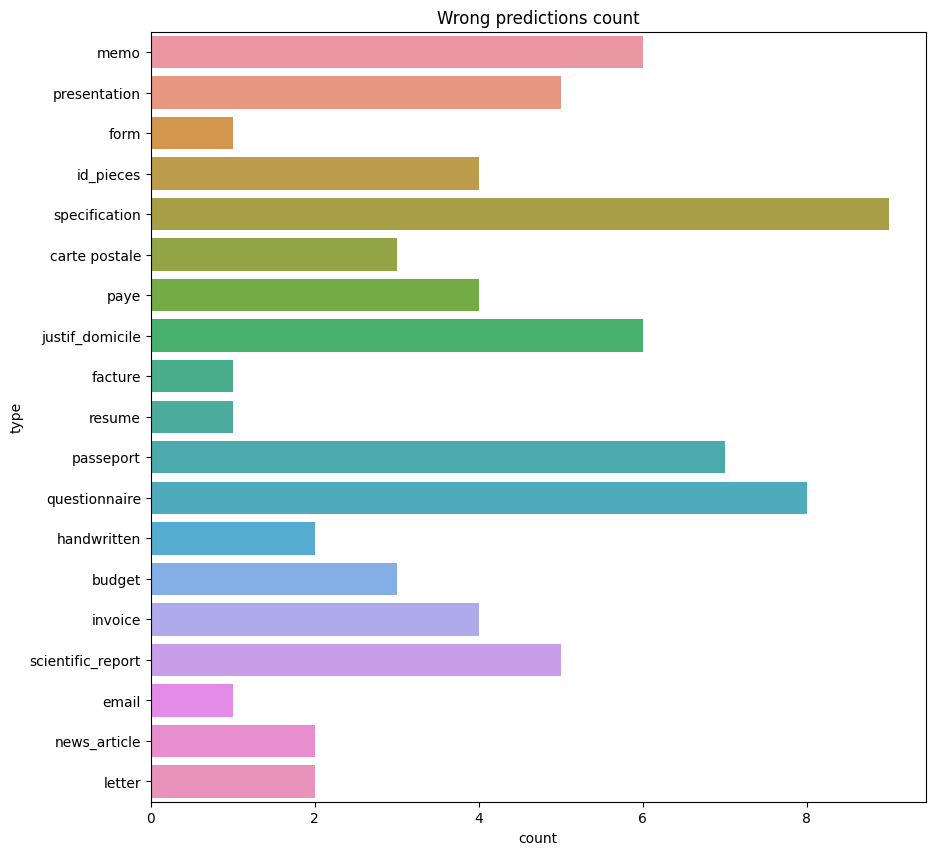

## Wrong predictions for specification

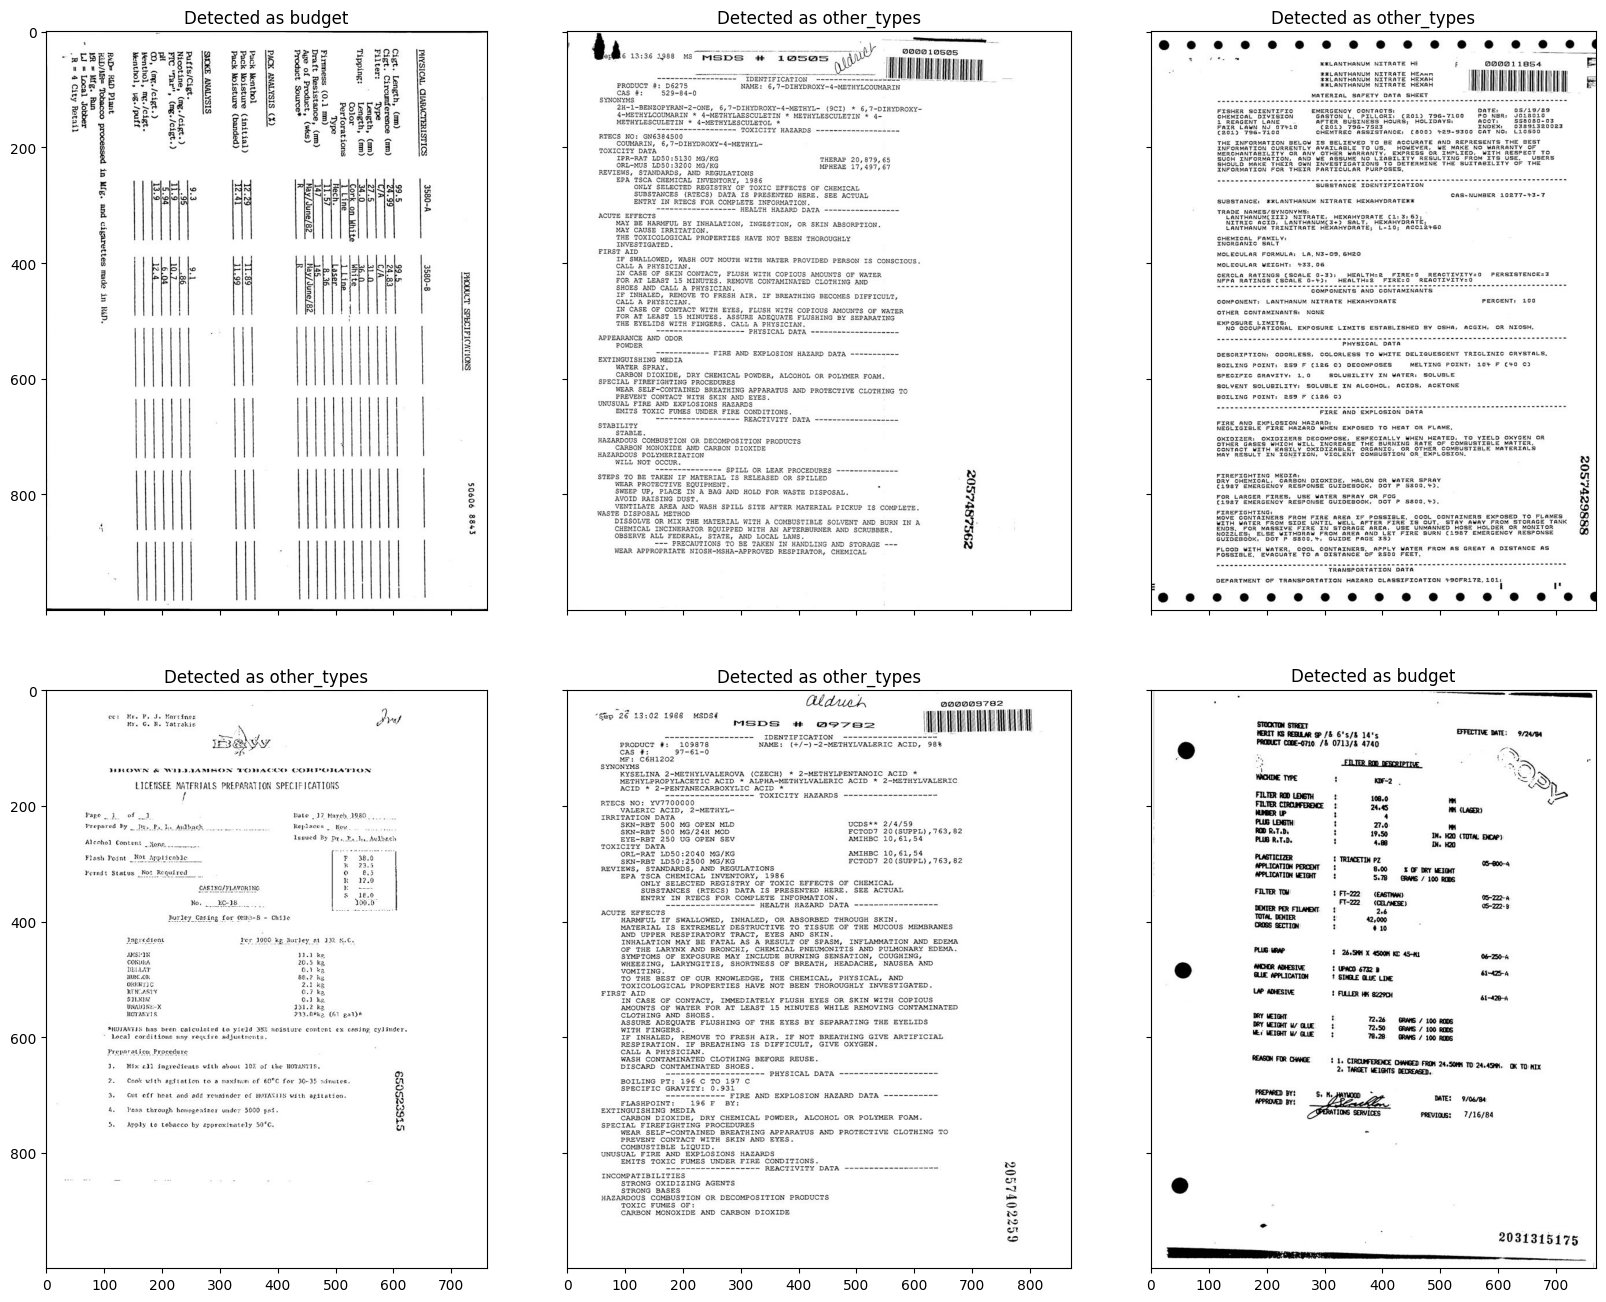

## Wrong predictions for questionnaire

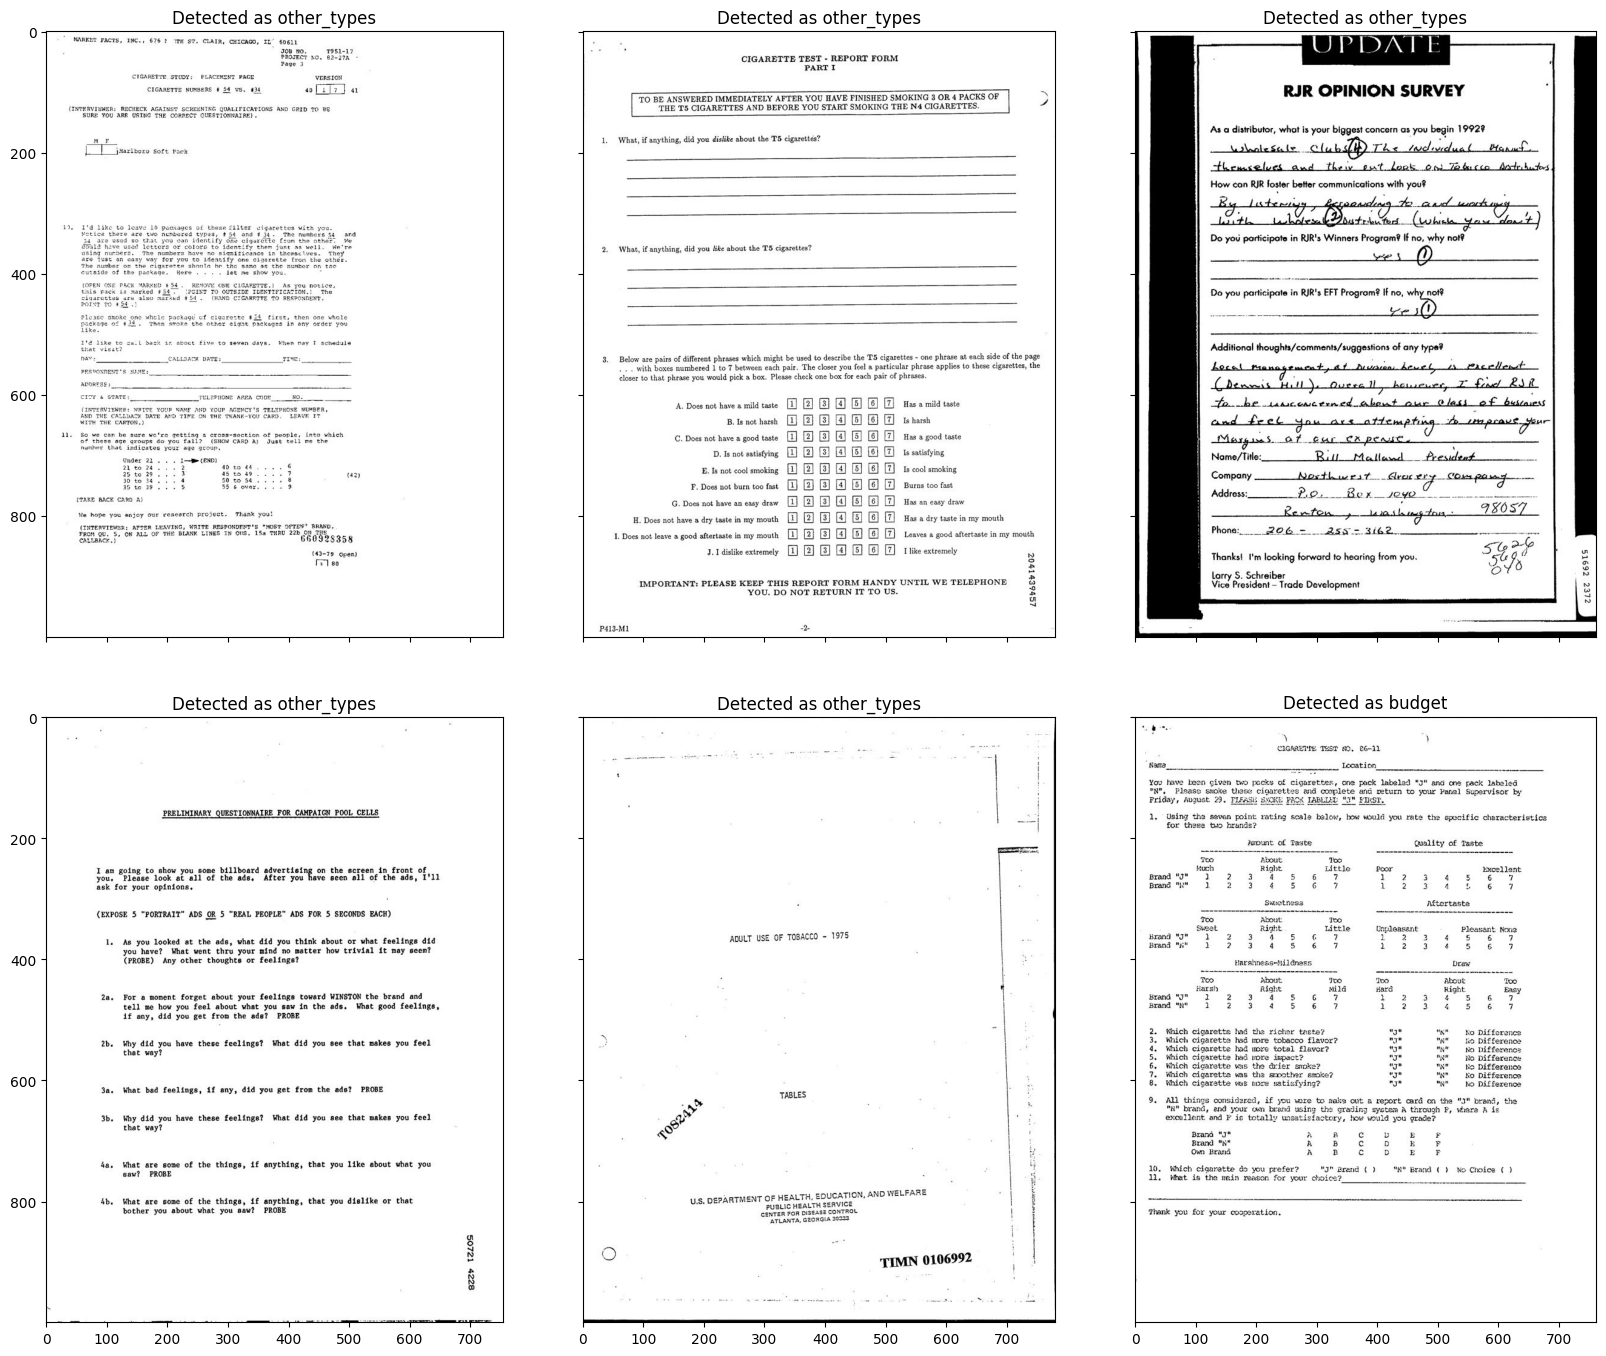

## Wrong predictions for passeport

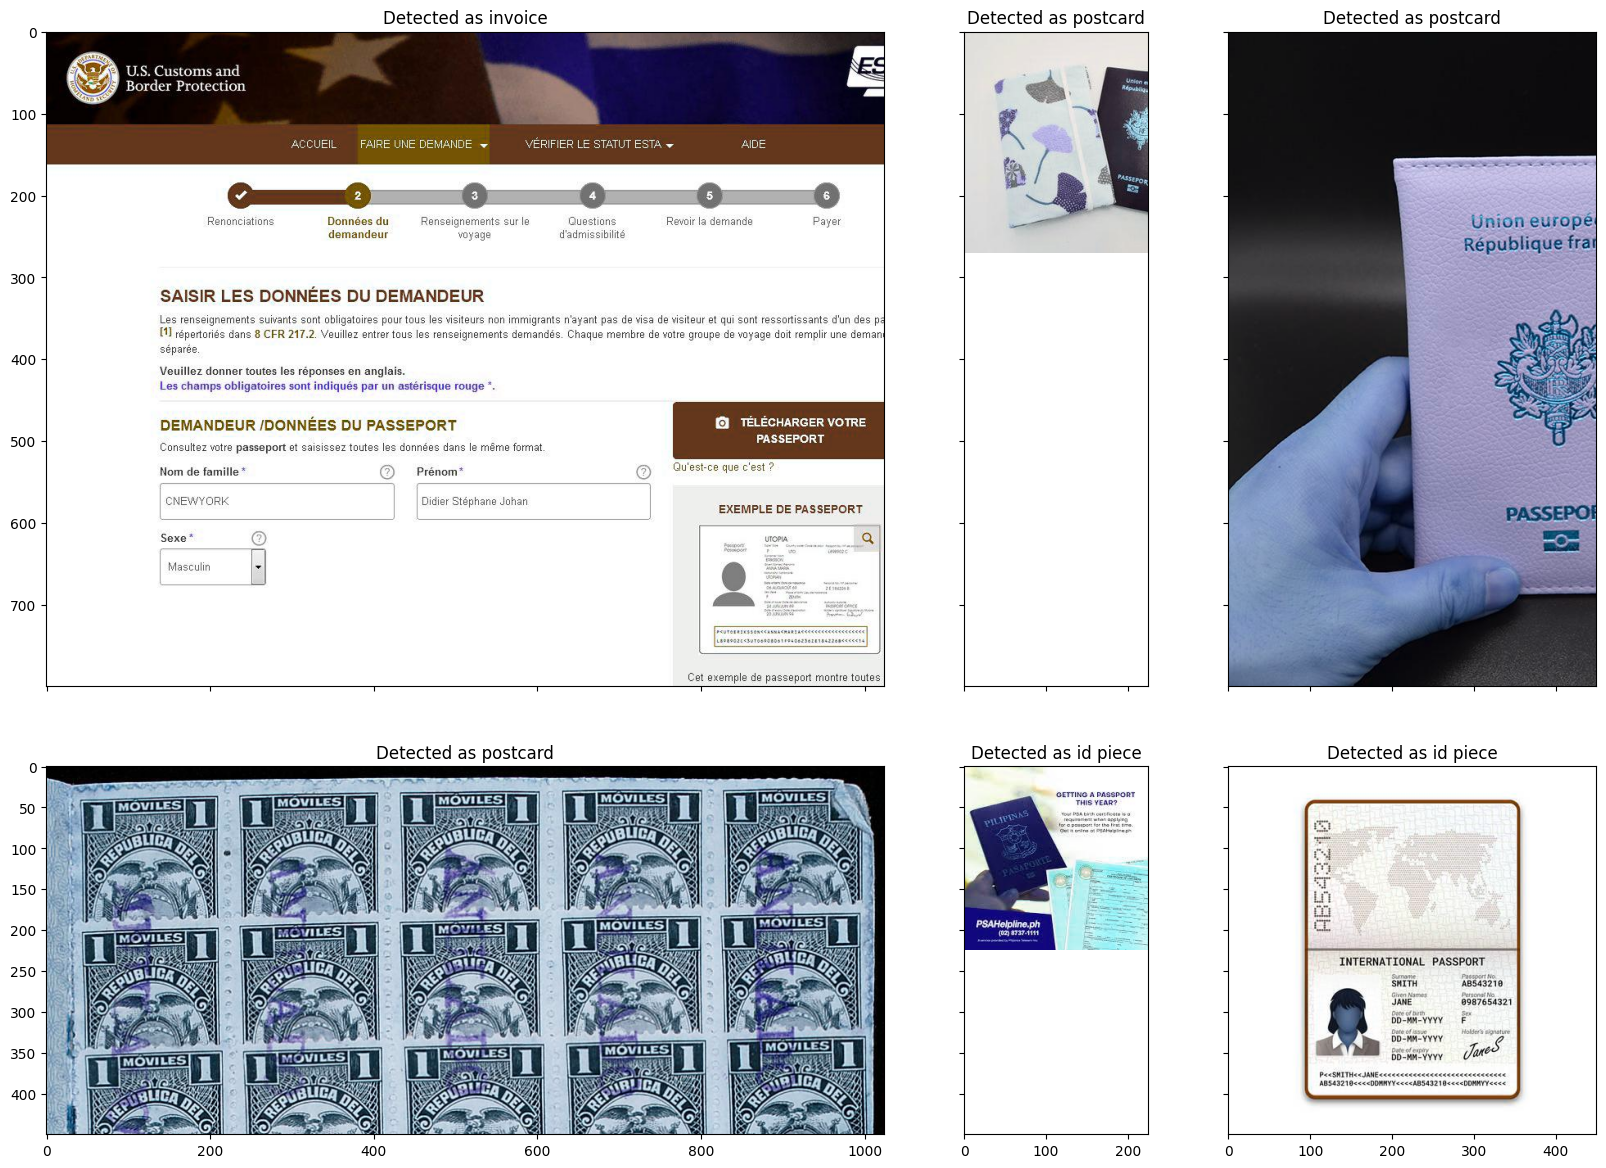

## Wrong predictions for memo

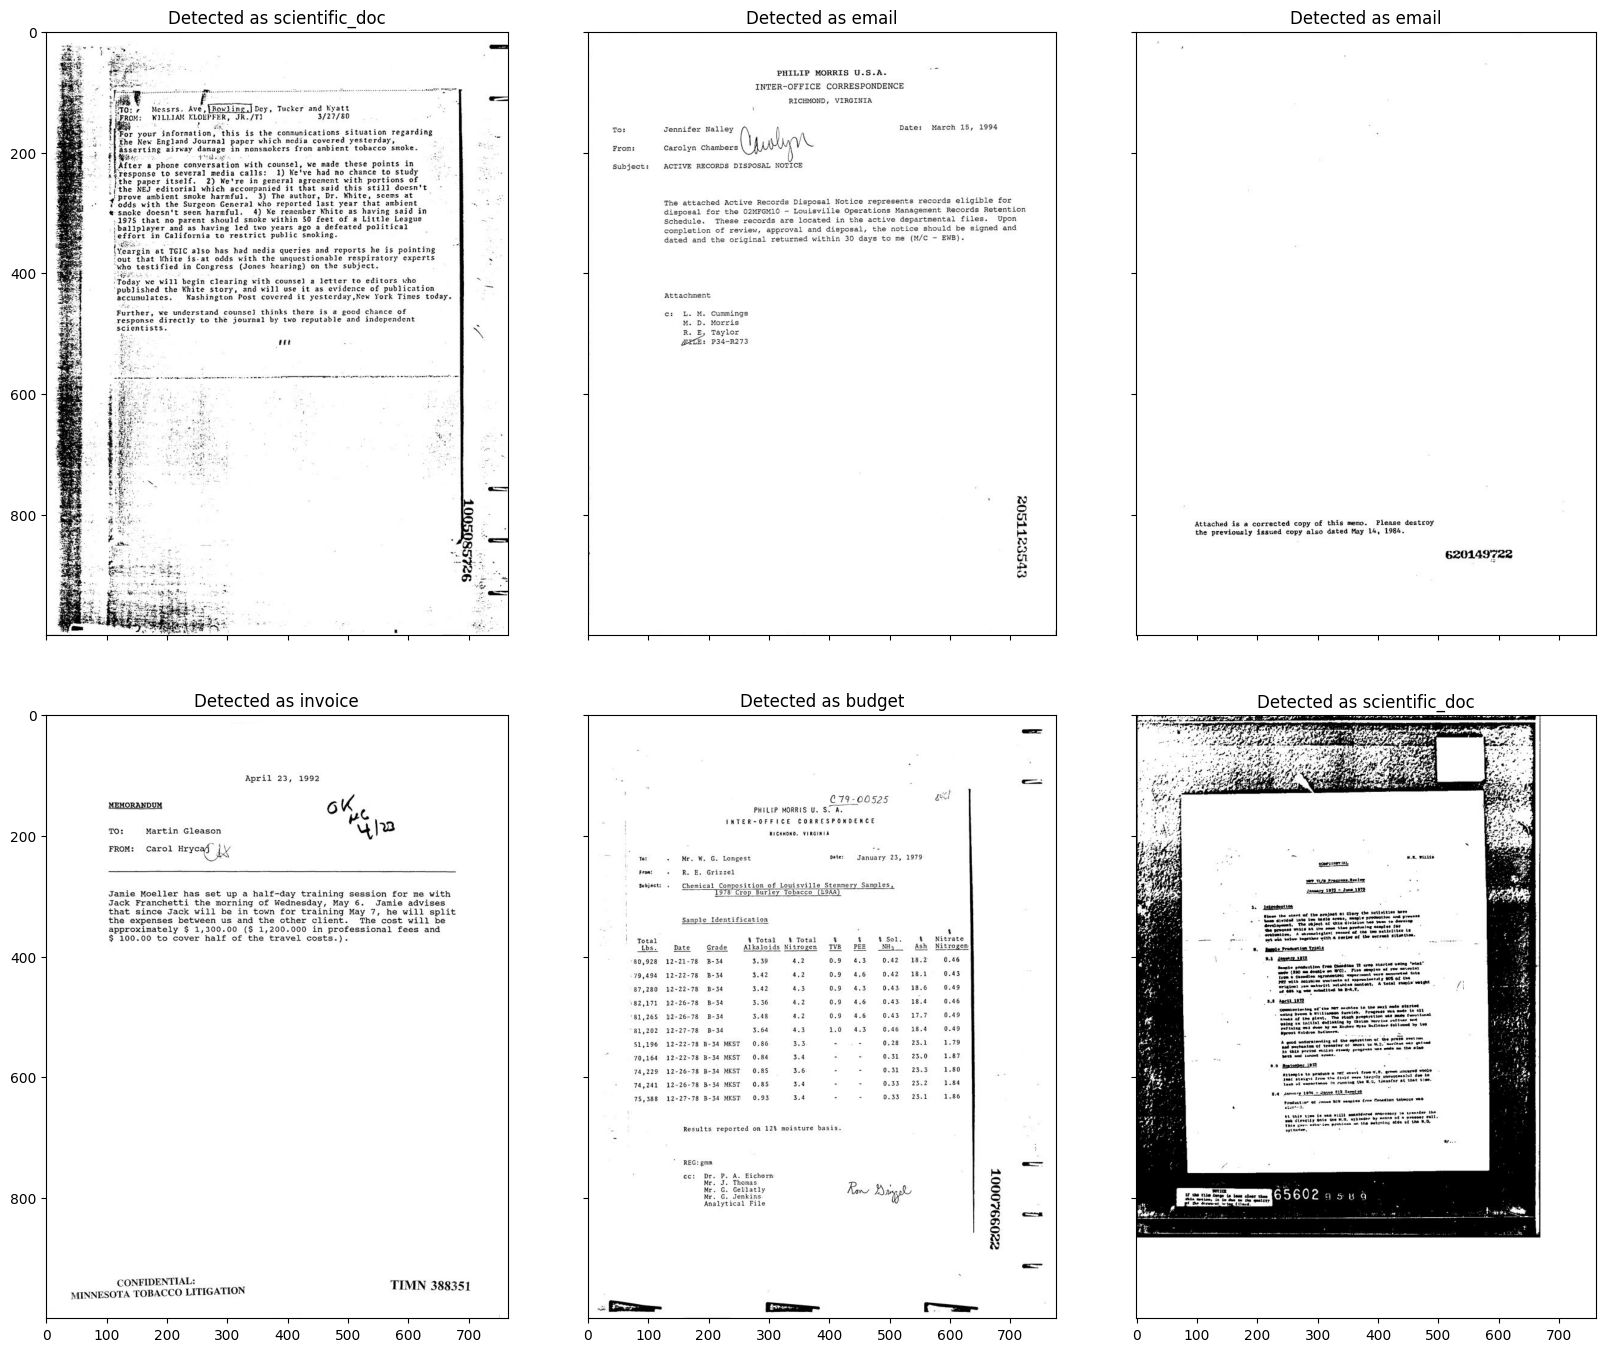

## Wrong predictions for justif_domicile

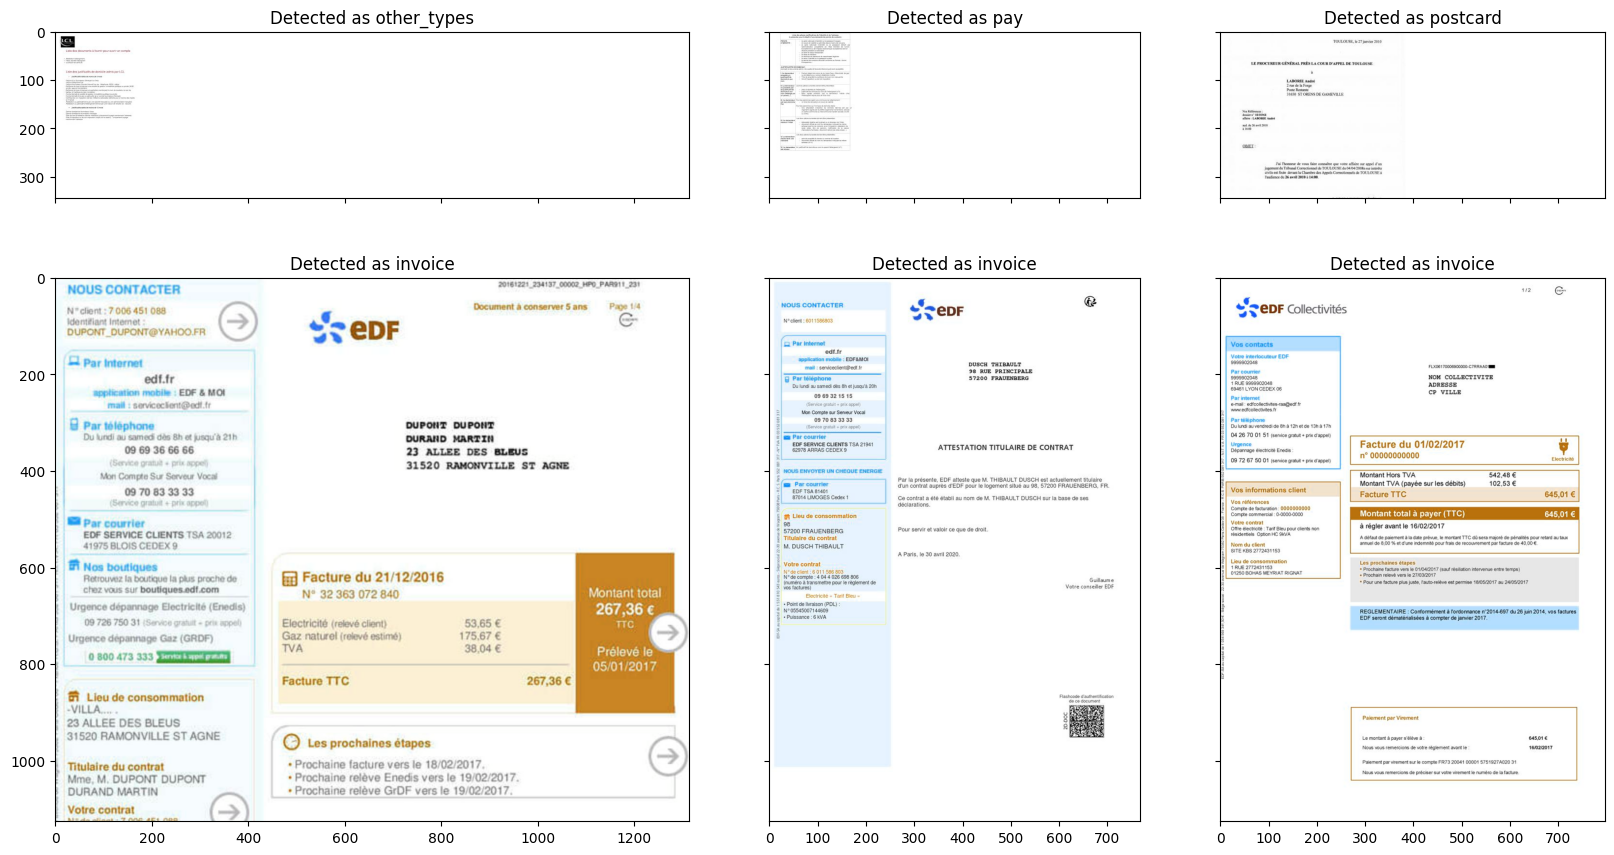

## Wrong predictions for scientific_report

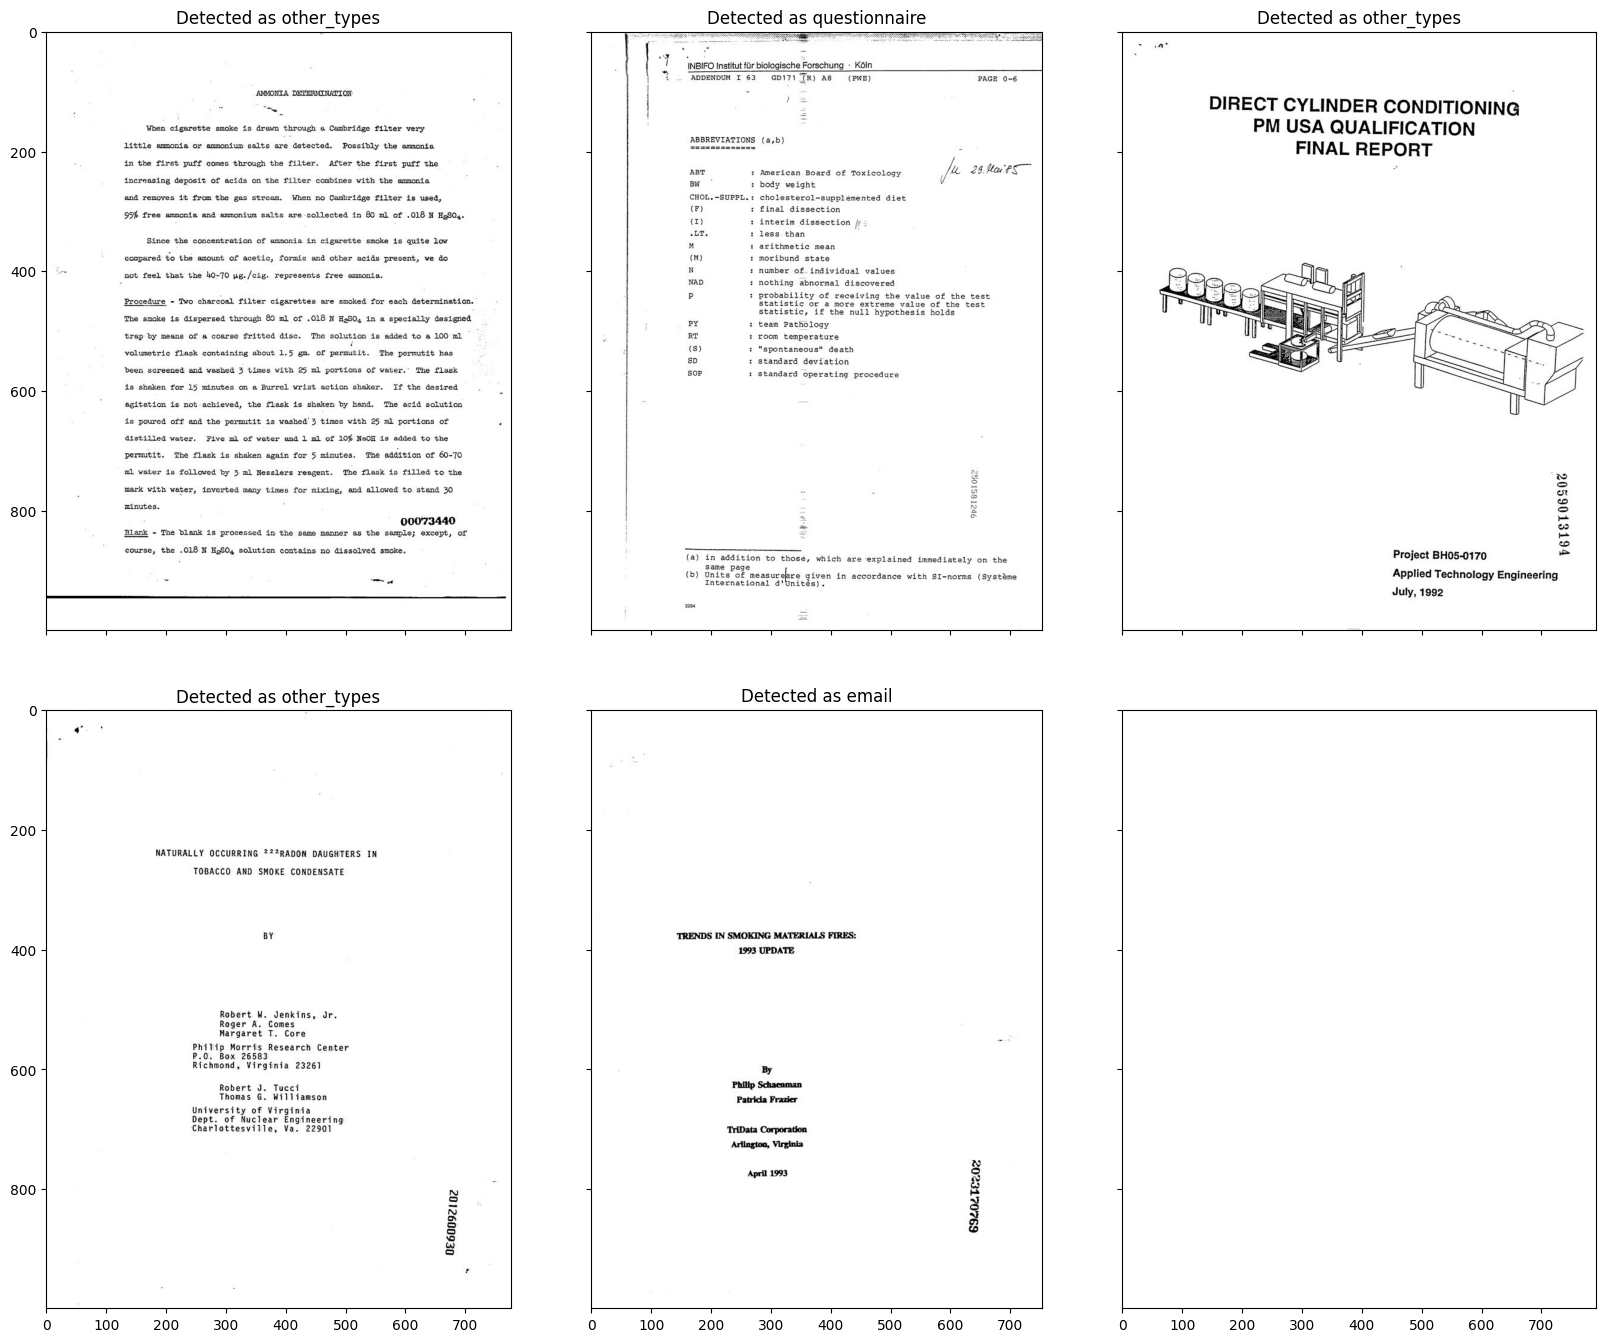

## Wrong predictions for presentation

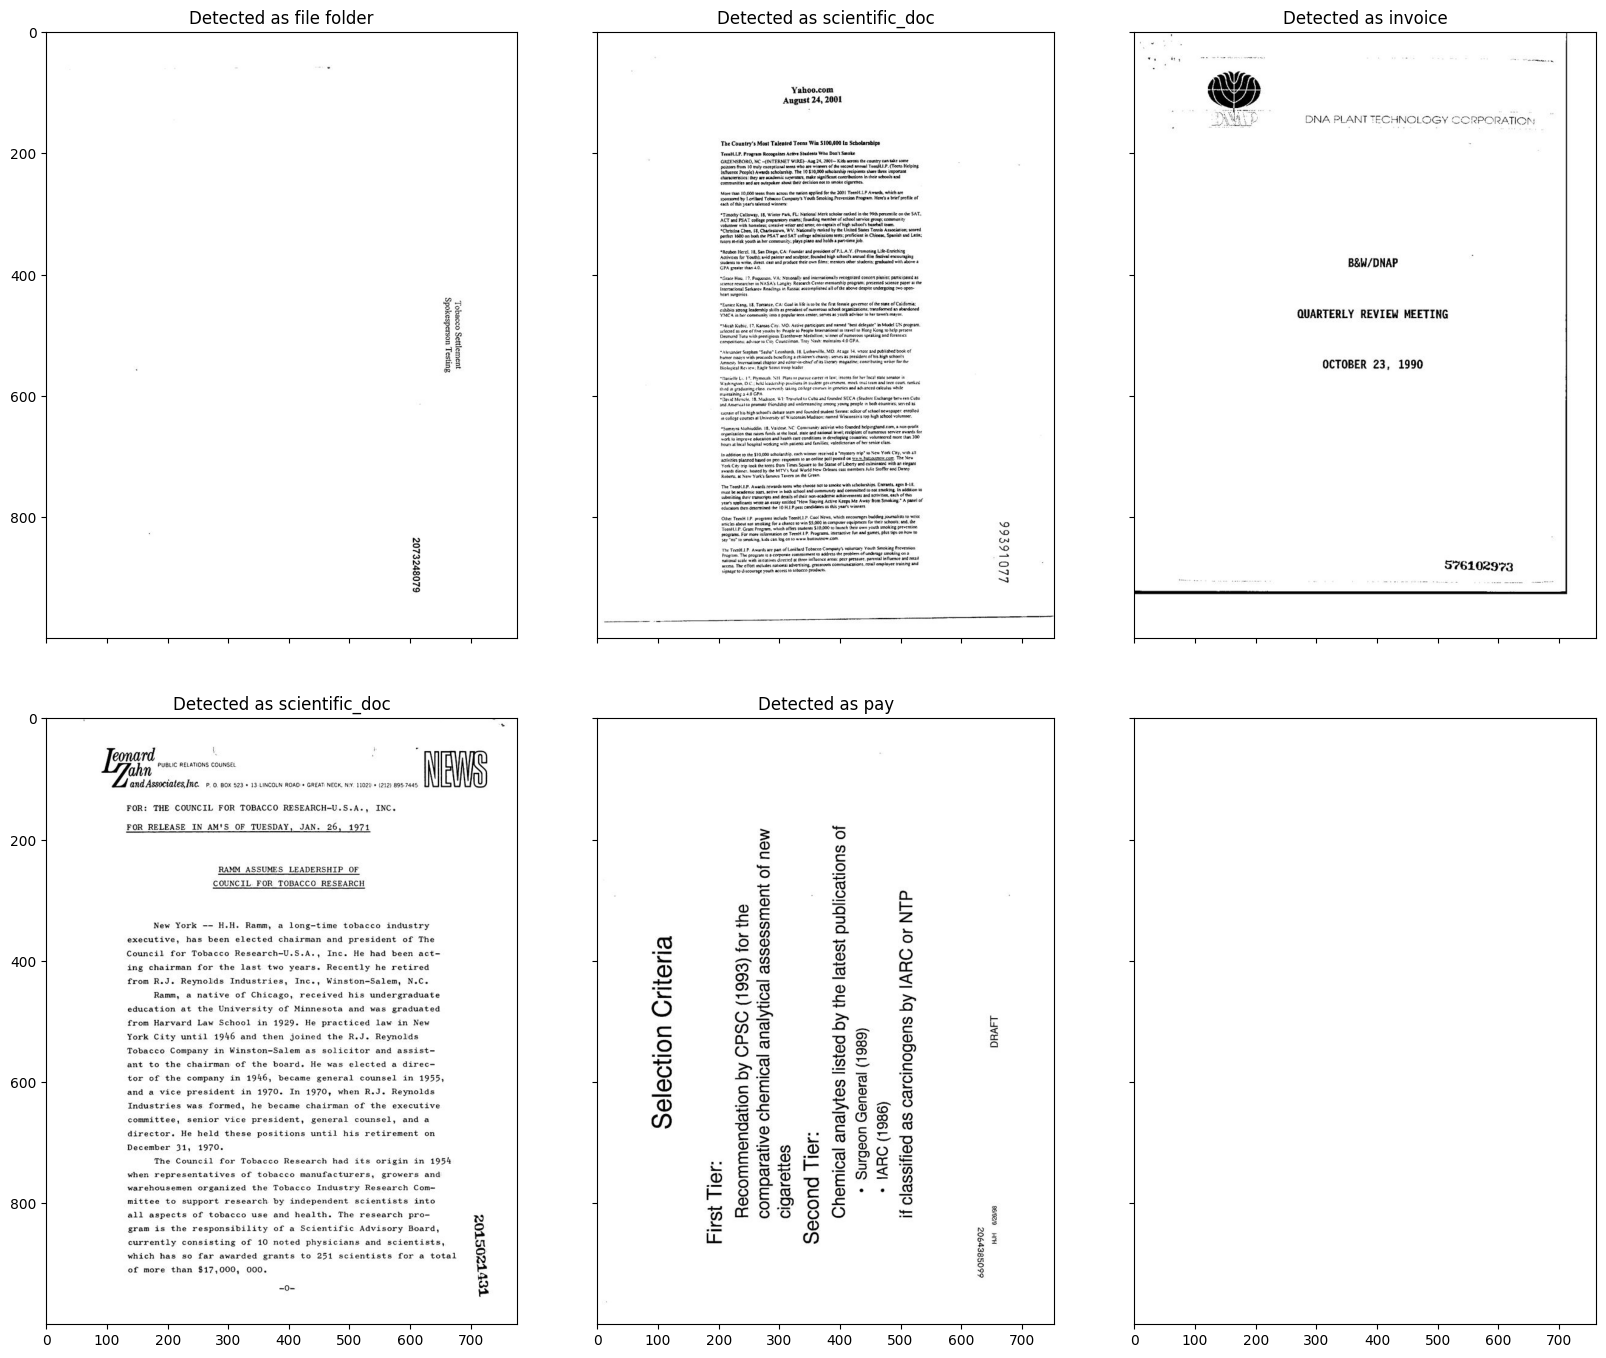

## Wrong predictions for id_pieces

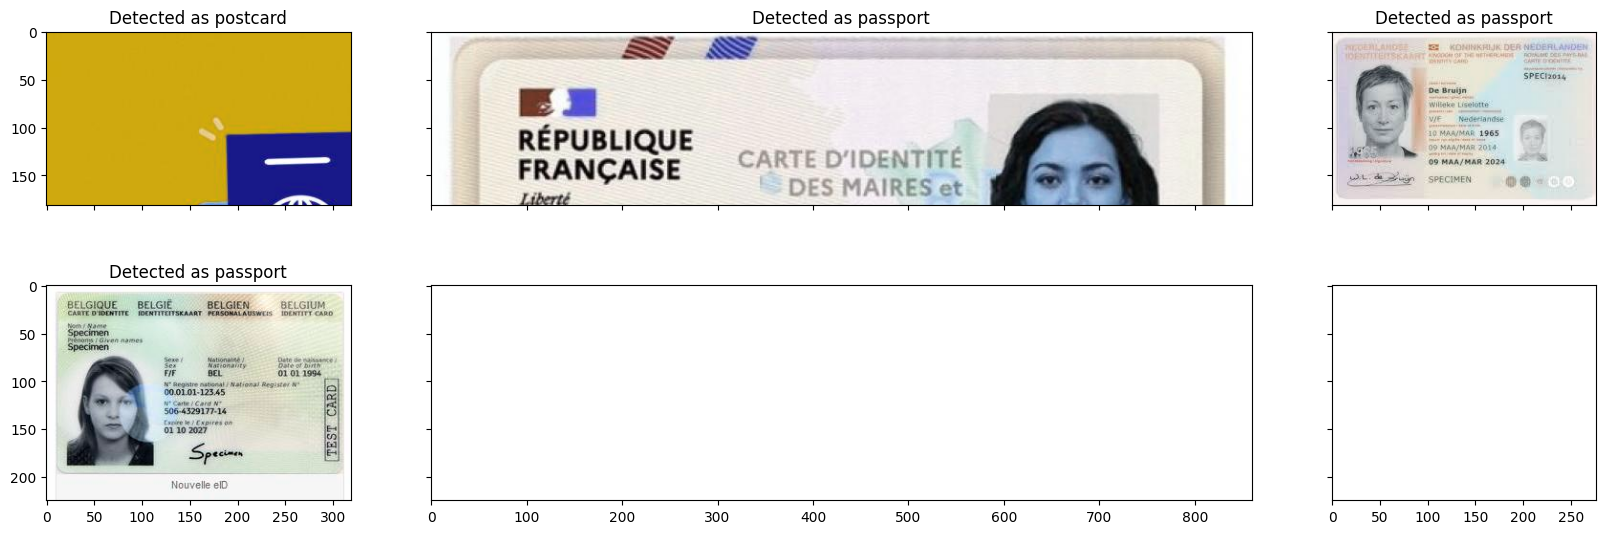

In [26]:
show_wrong_predictions(df, y_test, y_pred_type)